In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy import fftpack
from matplotlib.colors import LogNorm


%matplotlib inline


def plot_image(images, size=(4, 4)):
    if not isinstance(images, list):
        images = [images]
        
    fig, axs = plt.subplots(1, len(images), figsize=size,  dpi=150)
    
    for i, image in enumerate(images):
        ax = axs[i] if len(images) > 1 else axs

        ax.imshow(image, cmap='gray')
        ax.axis('off')
        
        
def get_histogram(image):
    pixels = list(image.getdata())
    histogram = [0 for i in range(256)]
    for pixel in pixels:
        histogram[pixel] += 1
    return histogram



def plot_hist(image):
    hist, _ = np.histogram(image, bins=256)
    plt.bar(range(256), hist, color='blue', width=1.0)

  
def color_correction_by_func(image, func):
    corrected_image = np.vectorize(func)(image)
    return corrected_image


def color_correction_by_normalizing_hist(image):
    corrected_image = color_correction_by_func(image, lambda x: (x - image.min()) / image.max())
    corrected_image *= 255
    return corrected_image

    
def ring(r):
    d = 2 * r + 1
    rx, ry = d / 2, d / 2
    x, y = np.indices((d, d))
    distance = np.hypot(rx - x, ry - y)
    mask = np.abs(distance - r) < 0.5
    return mask.astype('uint8')



image_bank = {}


def get_image(filename='img/memes1.jpg'):
    if filename in image_bank.keys():
        return image_bank[filename]
    
    img = cv2.imread(filename)
    image_bank[filename] = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return image_bank[filename]

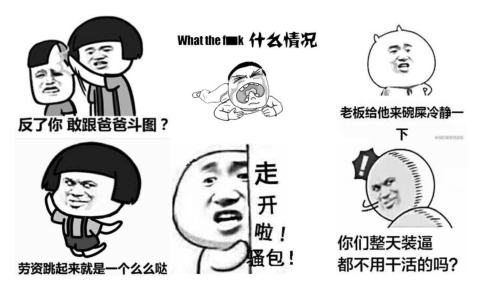

In [2]:
def norm(image):
    return cv2.normalize(image, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)


original_image = get_image()
# original_image = norm(original_image)
plot_image(original_image)

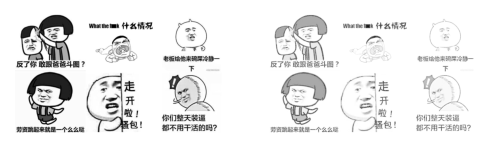

In [3]:
bad_function = lambda x: x**0.2
corrected_image = np.vectorize(bad_function)(original_image)

plot_image([original_image, corrected_image])
# original_image = (corrected_image - corrected_image.min()) / corrected_image.max()
# original_image = np.vectorize(round)(original_image * 255).astype('uint8')

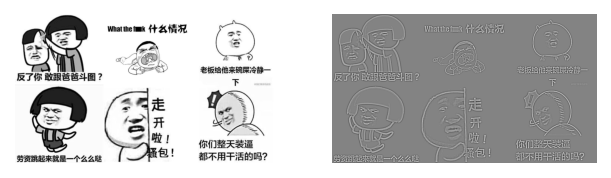

In [4]:
step1 = cv2.Laplacian(original_image, cv2.CV_64F, ksize=7)

plot_image([original_image, step1], size=(5, 5))

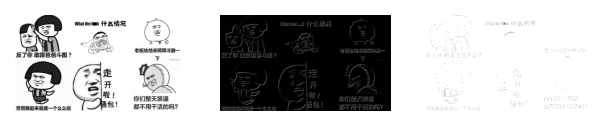

In [5]:
step2 = cv2.Sobel(original_image, ddepth=cv2.CV_64F, dx=1, dy=0)
step2 += cv2.Sobel(original_image, ddepth=cv2.CV_64F, dx=0, dy=1)
step2[step2 < 0] = 0
step3 = original_image + step2
step3[step3 > 1] = 1

plot_image([original_image, step2, step3], size=(5, 5))

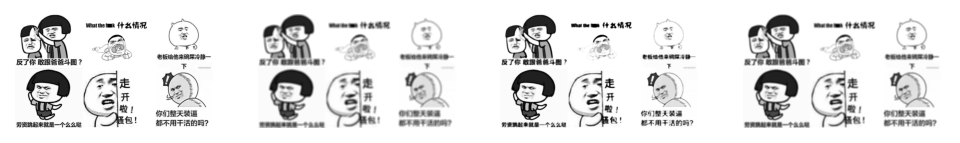

In [6]:
average = cv2.blur(original_image,(11,11))
median = cv2.medianBlur(original_image, 7)
gauss = cv2.GaussianBlur(original_image, (9, 9), 5)

plot_image([original_image, average, median, gauss], size=(8, 5))

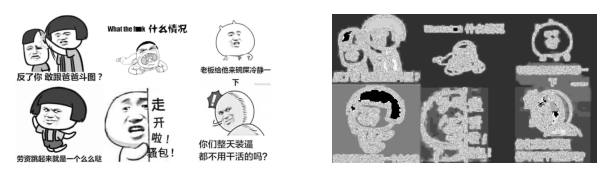

In [7]:
gauss_median = gauss * median

power_original = np.power(original_image, 0.65)
power_filters = np.power(gauss_median, 0.3)

plot_image([power_original, power_filters], size=(5, 5))

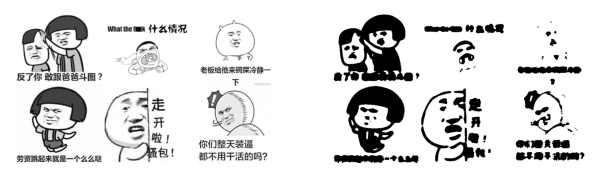

In [8]:
def erode(image, kernel, iterations=1):
    return cv2.erode(image, kernel, iterations)


def ellipse(size):
    return cv2.getStructuringElement(cv2.MORPH_ELLIPSE, size)


def dilate(image, kernel, iterations=1):
    return cv2.dilate(image, kernel, iterations)


def closure(image, kernel):
    return cv2.morphologyEx(image, cv2.MORPH_CLOSE, kernel)


minimum = average.min()
maximum = average.max()
normalized = (average - minimum) / maximum * 255
normalized = normalized.astype(np.uint8)
ret,thr = cv2.threshold(normalized, 0, 255, cv2.THRESH_OTSU)


plot_image([power_original, thr], size=(5, 5))

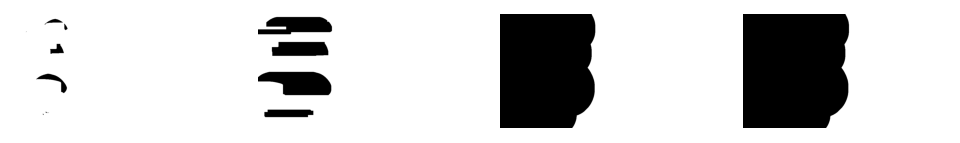

In [9]:
dilated1 = dilate(thr, np.ones((40, 30), dtype='uint8'))
eroded1 = erode(dilated1, np.ones((20, 200), dtype='uint8'))
eroded2 = erode(eroded1, ellipse((200, 200)))
eroded3 = erode(eroded2, ellipse((100, 20)))


plot_image([dilated1, eroded1, eroded2, eroded3], size=(8, 5))

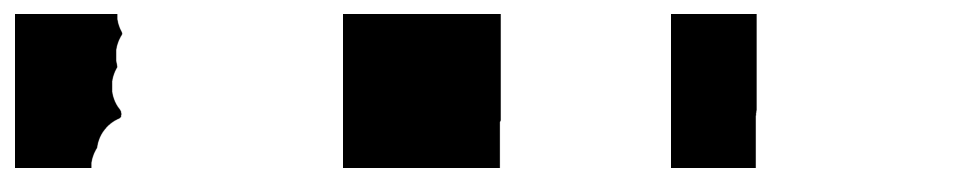

In [10]:
dilated2 = dilate(eroded3, ellipse((250, 250)))
eroded4 = erode(dilated2, np.ones((600, 350), dtype='uint8'))
dilated3 = dilate(eroded4, ring(250))

plot_image([dilated2, eroded4, dilated3], size=(8, 5))

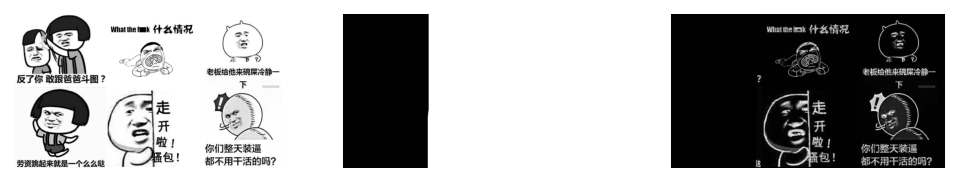

In [11]:
dilated4 = dilate(dilated3, np.ones((300, 50), dtype='uint8'))
kernel = np.ones((10, 100), dtype='uint8')
kernel[:, 50:] = np.zeros((10, 50), dtype='uint8')
dilated5 = dilate(dilated4, kernel) / 255
cropped = original_image * dilated3

plot_image([original_image, dilated3, cropped], size=(8, 5))

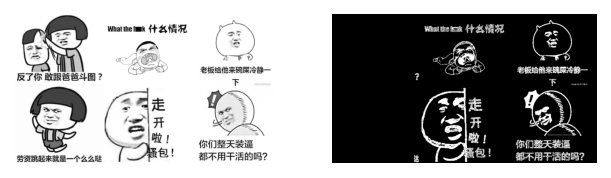

In [12]:
# ret,thr = cv2.threshold(cropped.astype(np.uint8), 0, 255, cv2.THRESH_OTSU)
cropped_copy = cropped.copy()

thr = 55
cropped_copy[cropped_copy > thr] = 255
cropped_copy[cropped_copy <= thr] = 0

plot_image([power_original, cropped_copy], size=(5, 5))

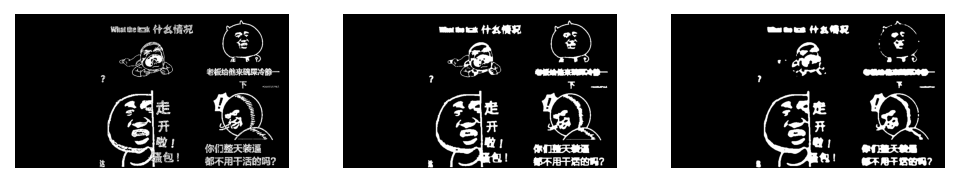

In [13]:
cropped_dilated = closure(cropped_copy, np.ones((4, 4), dtype='uint8'))
median_copy = cv2.medianBlur(cropped_dilated, 7)

plot_image([cropped_copy, cropped_dilated, median_copy], size=(8, 5))

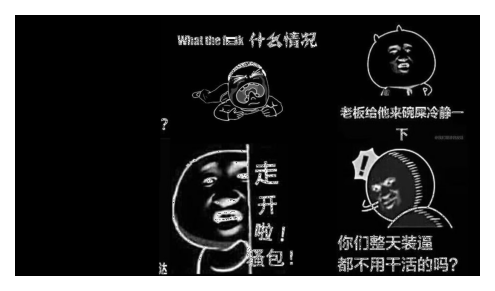

In [14]:
fft = np.fft.fft2(original_image)

plot_image([cropped])

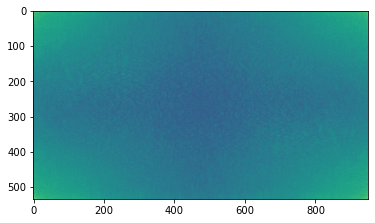

In [15]:
 plt.imshow(np.abs(fft), norm=LogNorm(vmin=5))

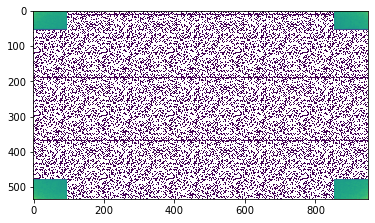

In [16]:
# In the lines following, we'll make a copy of the original spectrum and
# truncate coefficients.

# Define the fraction of coefficients (in each direction) we keep
keep_fraction = 0.1

# Call ff a copy of the original transform. Numpy arrays have a copy
# method for this purpose.
im_fft2 = fft.copy()

# Set r and c to be the number of rows and columns of the array.
r, c = im_fft2.shape

# Set to zero all rows with indices between r*keep_fraction and
# r*(1-keep_fraction):
im_fft2[int(r*keep_fraction):int(r*(1-keep_fraction))] = 0

# Similarly with the columns:
im_fft2[:, int(c*keep_fraction):int(c*(1-keep_fraction))] = 0

plt.imshow(np.abs(im_fft2), norm=LogNorm(vmin=5))

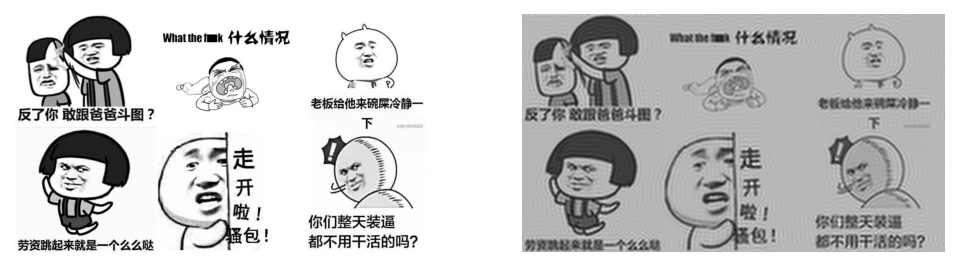

In [17]:
im_new = np.fft.ifft2(im_fft2).real

plot_image([original_image, im_new], size=(8,5))
# cv2.imwrite('fft.jpg', im_new)

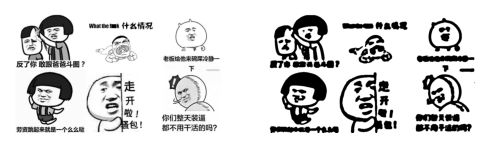

In [18]:
# original_image = get_image()
# original_image = norm(original_image)


thresholded = cv2.adaptiveThreshold(average, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 101, 2)

plot_image([original_image, thresholded])

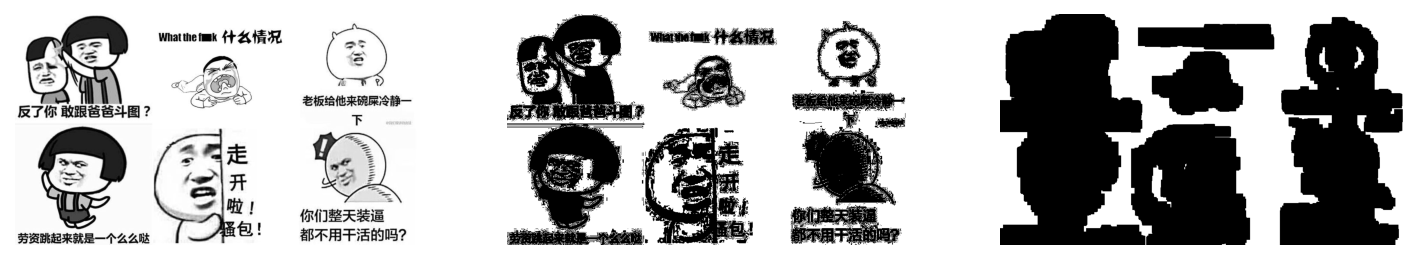

In [19]:
# original_image = cv2.imread('img/bad_document_4.jpg', cv2.IMREAD_GRAYSCALE)
# original_image = norm(original_image)


thresholded = cv2.adaptiveThreshold(original_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 6001, 2)

plot_image([original_image, thresholded, erode(thresholded, np.ones((20, 20), dtype='uint8'))], size=(12, 5))


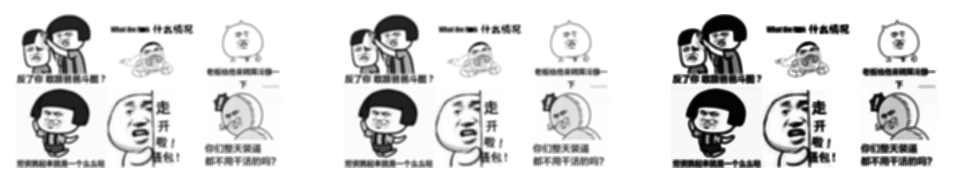

In [20]:
# original_image = cv2.imread('img/bad_document.JPG', cv2.IMREAD_GRAYSCALE)

minimum = original_image.min()
maximum = original_image.max()

normalize = np.vectorize(lambda x: 255 * (x - minimum) / (maximum - minimum))
levels = 256 * 256 - 1
quad_normalize = np.vectorize(lambda x: levels * ((x - minimum) / (maximum - minimum))**2)

plot_image([average, normalize(average), quad_normalize(average)], size=(8, 8))

In [46]:
# original_image = cv2.imread('img/bad_document_4.jpg', cv2.IMREAD_GRAYSCALE)
def to_bit_surfaces(image):
    bits = []
    for i in range(0, 8):
        bits.append(image & (2**i))
    
    return bits

bits = to_bit_surfaces(original_image)
# original_image

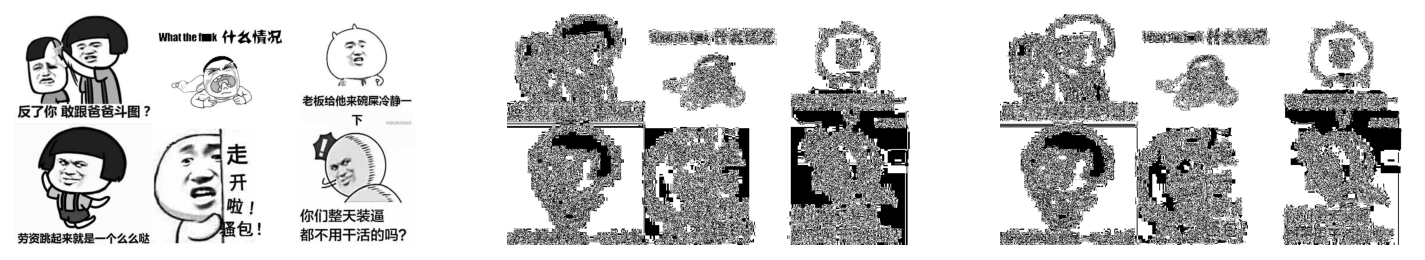

In [47]:
plot_image([original_image, bits[0], bits[1]], size=(12, 8))

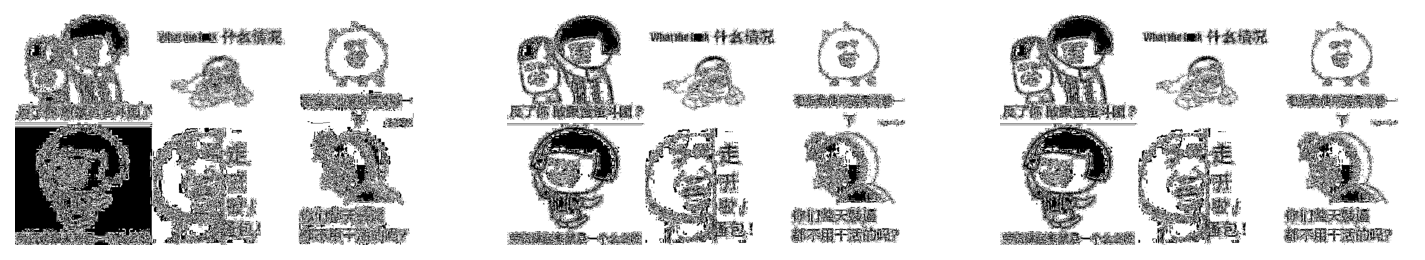

In [48]:
plot_image([bits[2], bits[3], bits[3]], size=(12, 8))

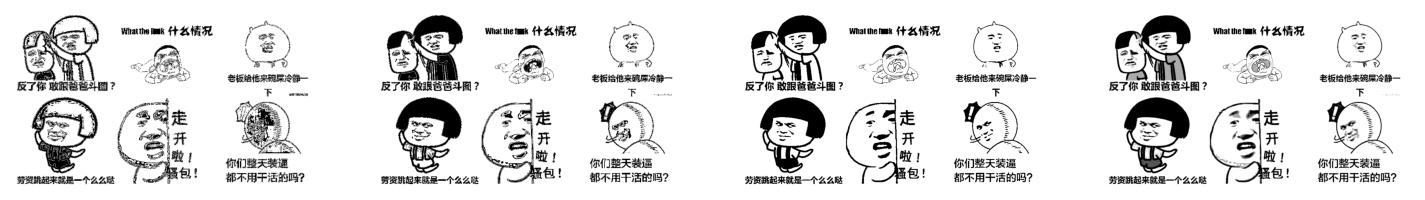

In [50]:
restored = bits[6] + bits[7]

plot_image([bits[5], bits[6], bits[7], restored], size=(12, 8))

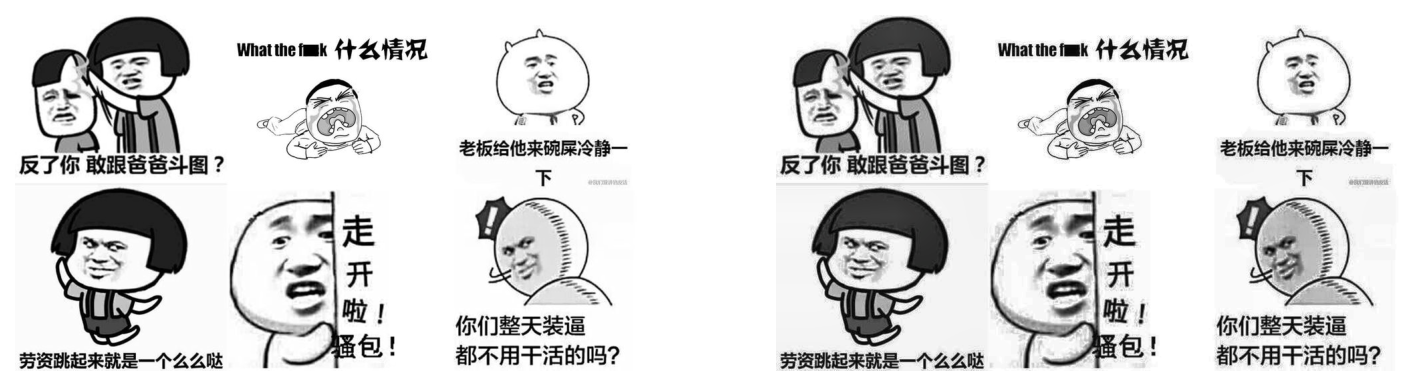

In [25]:
def CLAHE(img):
    #-----Converting image to LAB Color model----------------------------------- 
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)

    #-----Splitting the LAB image to different channels-------------------------
    l, a, b = cv2.split(lab)
    cv2.imshow('l_channel', l)
    cv2.imshow('a_channel', a)
    cv2.imshow('b_channel', b)

    #-----Applying CLAHE to L-channel-------------------------------------------
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
    cl = clahe.apply(l)

    #-----Merge the CLAHE enhanced L-channel with the a and b channel-----------
    limg = cv2.merge((cl,a,b))

    #-----Converting image from LAB Color model to RGB model--------------------
    final = cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)
    return final

plot_image([original_image, CLAHE(cv2.cvtColor(original_image, cv2.COLOR_GRAY2BGR))], size=(12, 5))

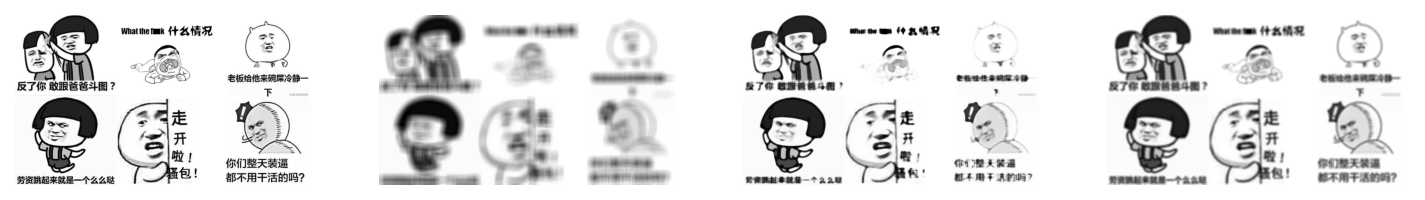

In [26]:
def filters(image):
    average = cv2.blur(image,(25,25))
    median = cv2.medianBlur(image, 9)
    gauss = cv2.GaussianBlur(image, (9, 9), 5)
    
    return [average, median, gauss]


plot_image([original_image, *filters(original_image)], size=(12, 5))

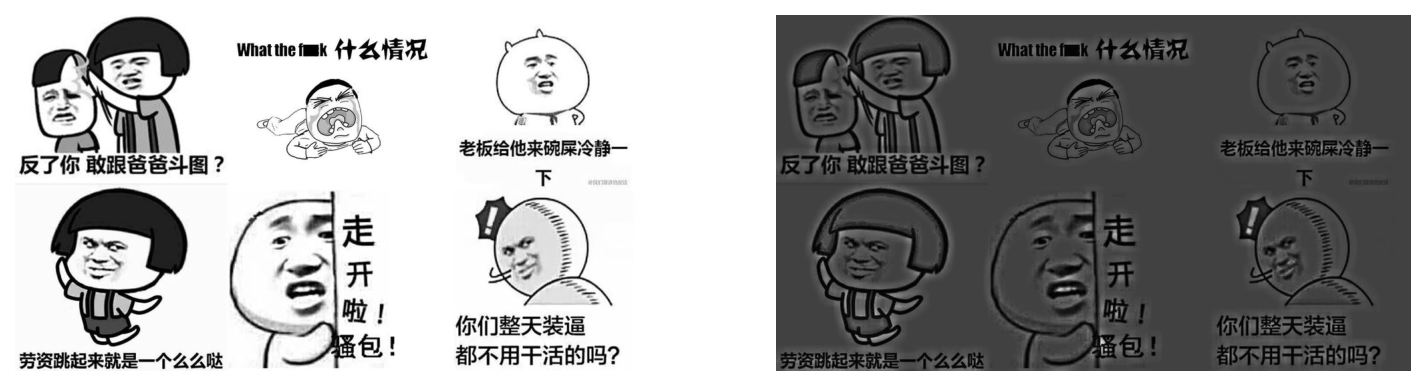

In [27]:
def delete_light(image):
    image = CLAHE(cv2.cvtColor(image, cv2.COLOR_GRAY2BGR))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    average, _, _ = filters(image)
    image = image.astype('uint16') / average
    return image
    
    
without_light = delete_light(original_image)
without_light -= without_light.min()
without_light /= without_light.max()
without_light *= 255
without_light = without_light.astype(np.uint8)

plot_image([original_image, without_light], size=(12, 5))

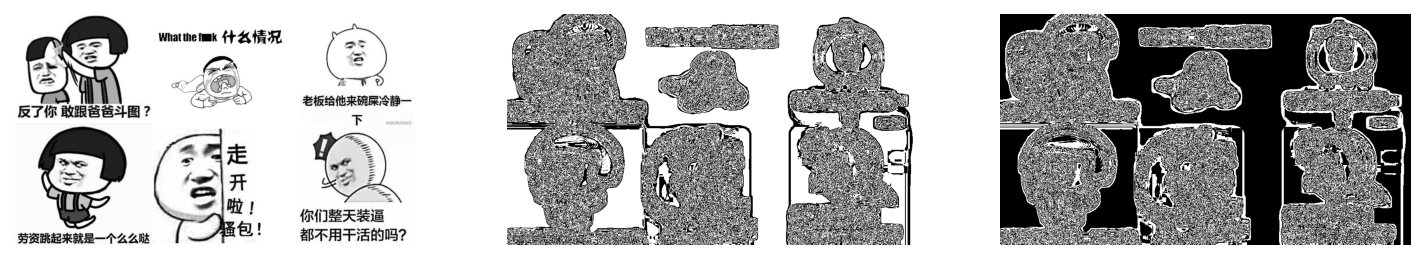

In [28]:
bits = to_bit_surfaces(without_light)

plot_image([original_image, bits[0], bits[1]], size=(12, 8))

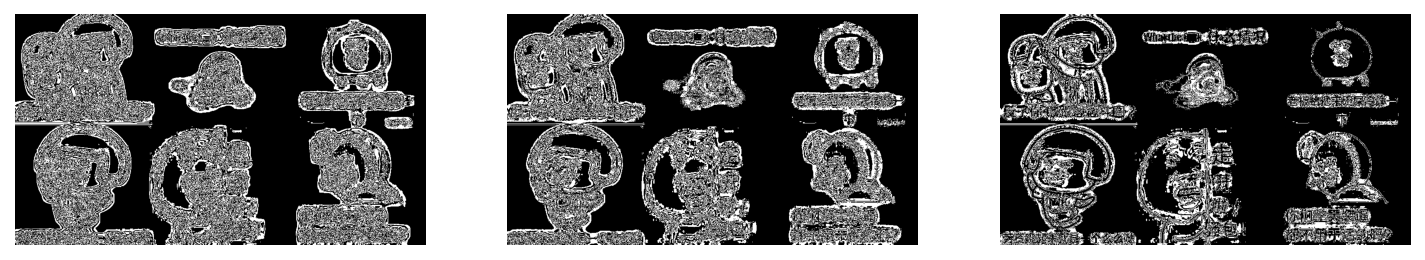

In [29]:
plot_image([bits[2], bits[3], bits[4]], size=(12, 8))

True

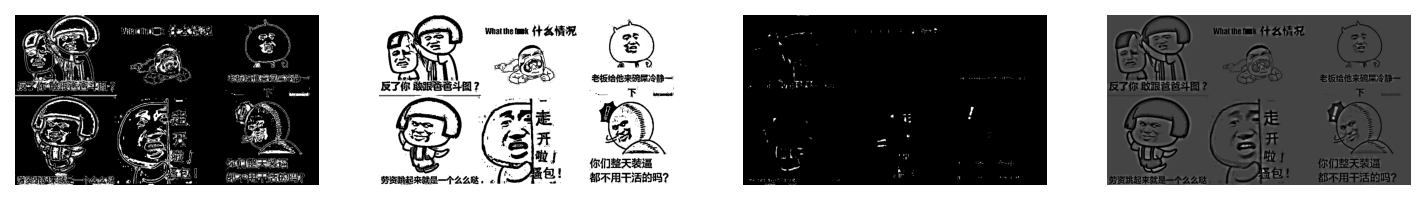

In [30]:
restored = bits[4] + bits[5] + bits[6] + bits[7] 

plot_image([bits[5], bits[6], bits[7], restored], size=(12, 8))

# restored = (restored - restored.min()) / restored.max()
# restored *= 255

cv2.imwrite('restored.jpg', dilate(restored, np.ones((1, 1), dtype=np.uint8)))
cv2.imwrite('restored.jpg', restored)

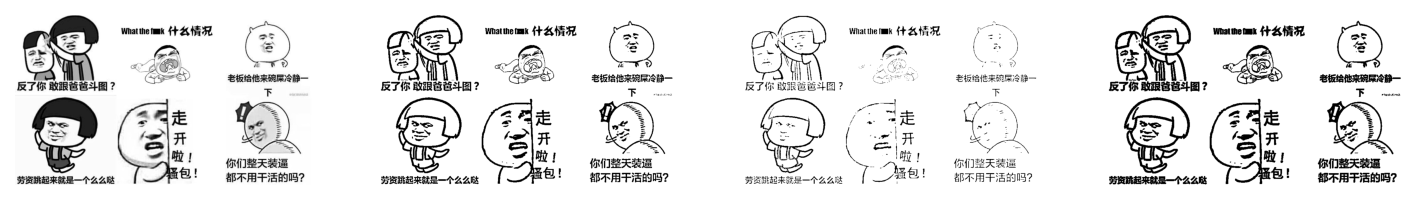

In [31]:
from skimage.filters import (threshold_otsu, threshold_niblack,
                             threshold_sauvola)


def sauvola_thresholding(image):
    thresh_sauvola = threshold_sauvola(image)
    sauvola = original_image > thresh_sauvola
    return sauvola


restored[restored > 0] = 1
sauvola_thresh = sauvola_thresholding(original_image) * 1
new_image = sauvola_thresh * restored 

plot_image([original_image, sauvola_thresh, restored, erode(new_image.astype(np.uint8), ellipse((2, 2)))], size=(12, 8))

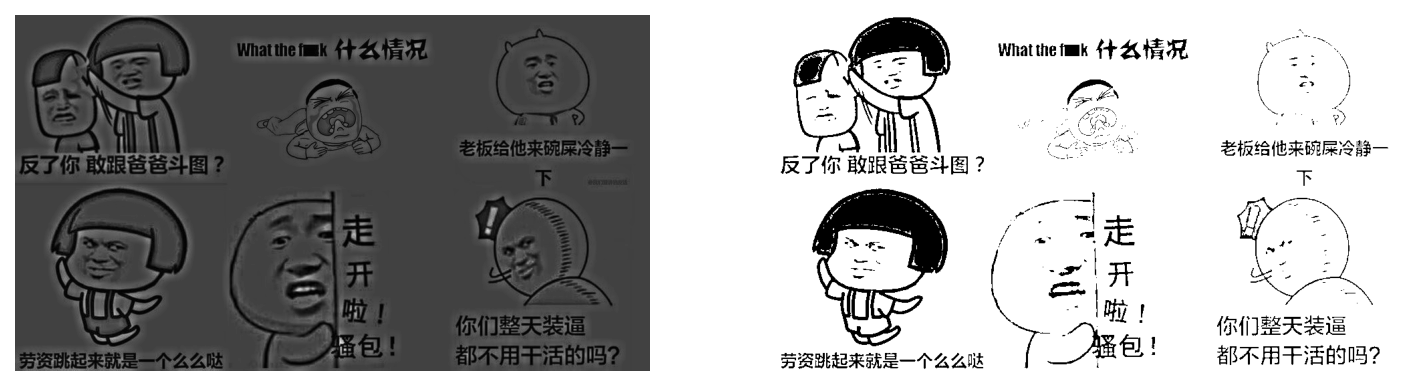

In [32]:

plot_image([without_light, sauvola_thresholding(without_light)], size=(12, 8))

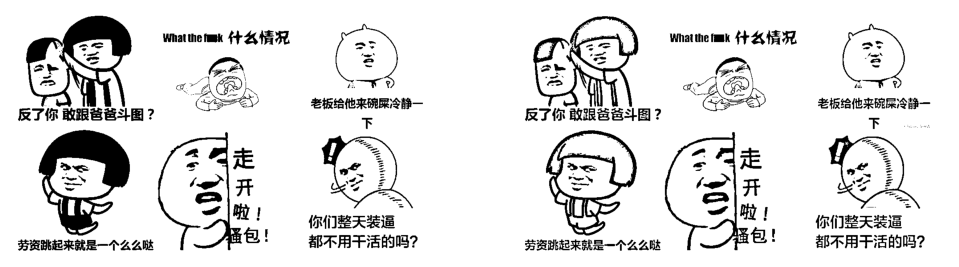

In [33]:
def thresholds(images):
    results = []
    for i in range(len(images)):
        _, thr = cv2.threshold(images[i], 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        results.append(thr)
    return results

    
plot_image([*thresholds([original_image, without_light])], size=(8, 8))
# cv2.imwrite('restored.jpg', adapt_mean)

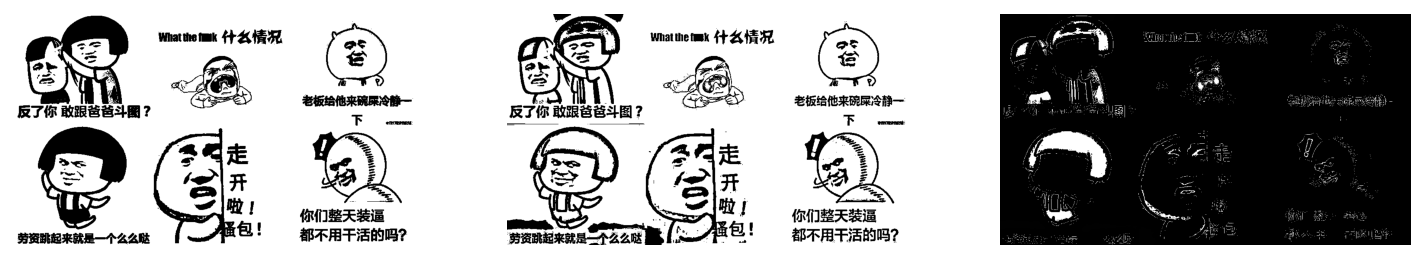

In [34]:
orig_adapt_mean = cv2.adaptiveThreshold(original_image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 151, 5)
without_light_adapt_mean = cv2.adaptiveThreshold(without_light, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 151, 5)

cv2.imwrite('binarize.jpg', without_light_adapt_mean)

plot_image([
    orig_adapt_mean, without_light_adapt_mean, (without_light_adapt_mean - orig_adapt_mean)
], size=(12,8))

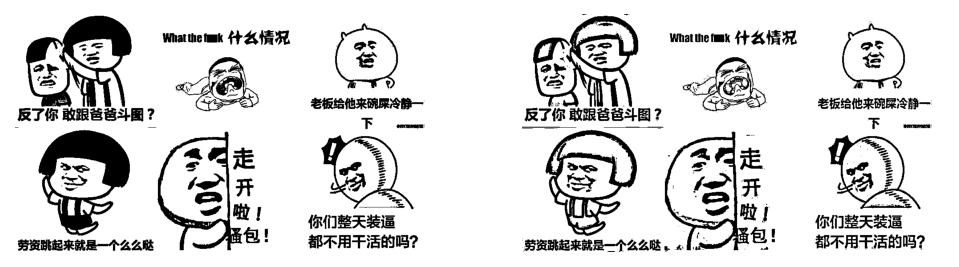

In [35]:
plot_image([
    cv2.adaptiveThreshold(original_image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 151, 5),
    cv2.adaptiveThreshold(without_light, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 151, 5)
], size=(8,8))

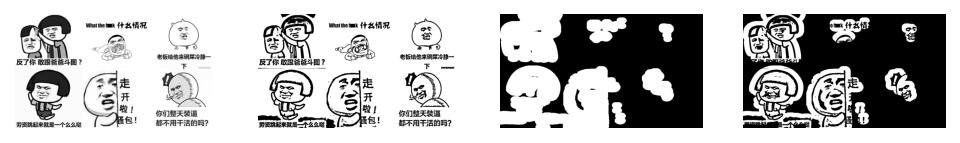

In [36]:
denoised = dilate(without_light_adapt_mean, ring(3))
denoised = erode(denoised, ring(13))
denoised = dilate(denoised, ellipse((10,10)))
denoised = erode(denoised, ellipse((40,30)))
denoised = 255 - denoised

plot_image([original_image, without_light_adapt_mean, denoised, denoised * without_light_adapt_mean], size=(8, 8))